In [1]:
import tensorflow as tf
from keras.models import Model
from keras.optimizers import Adam
from keras import layers, callbacks

from keras.utils import to_categorical

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 
import numpy as np

from tensorflow.python.keras.utils.vis_utils import plot_model
import pydot

from scipy.stats import norm
from scipy import stats
import os

from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
from sklearn.utils.class_weight import compute_class_weight
import dataframe_image as dfi
import pickle
import math

2023-05-10 12:27:23.088771: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-05-10 12:27:23.114979: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
channel_width = 5
time_data_amount = 20
nr_classes = 3

using_weights = False

#### Save parameters

In [3]:
name = 'multi_channels_test' #name of model - should be descriptive
save_folder = 'template_Multi' + str(time_data_amount) #hyperparameter description her
if using_weights == True:
    save_folder = save_folder + '_W'
    name = name + '_weighted'

### Gotta load in some data

In [4]:
datapath = '../../../All generated data/'
labelpath = '../../../All generated labels/'
data_list = os.listdir(datapath)
#print(data_list)

#all_data = [] #if we want to have data and labels in one list
all_datapoints = []
all_labels = []

total_channels = 79
total_scans_pr_sample = 20


for csv_file in data_list:
    data_file = datapath + csv_file
    current_data_file = pd.read_csv(data_file,header=None)

    label_file = labelpath + csv_file
    label_file = label_file.replace('.csv', '_labels.csv')
    current_label_file = pd.read_csv(label_file,header=None)

    for data_iter in range(len(current_data_file.index)):
        #Pulling out the data from a row and putting it in the list
        current_data_point = np.array(current_data_file.iloc[data_iter])
        current_data_point = current_data_point.reshape(total_scans_pr_sample,total_channels)
        all_datapoints.append(current_data_point)
        
        #adding the label to the datamatrix as the last row
        label_row = np.array(current_label_file.iloc[data_iter])
        label_row = label_row.reshape(1,total_channels)
        all_labels.append(label_row)
        
        #all_data.append(np.vstack([current_data_point, label_row])) #if we want to have data and labels in one list


In [5]:
print(all_labels[1].shape)
print(len(all_labels))
print(len(all_datapoints))

(1, 79)
10981
10981


#### Pick out one channel for each sample
For now it takes the same channel for all samples

In [6]:
complete_data = []
complete_labels = []

lower_channel = math.floor(channel_width/2)
upper_channel = math.ceil(channel_width/2)

chosen_channels = list(range(upper_channel+1,79-upper_channel,channel_width))

# check if channels are viable
for channel in chosen_channels:
        if (channel - lower_channel) < 0 or (channel + upper_channel - 1) > total_channels:
            print('Bad channel choice')
            exit()
        if channel_width % 2 == 0:
            print('please pick uneven channel width')
            exit()


for iter in range(len(all_datapoints)):
    for channel in chosen_channels:
        complete_data.append(all_datapoints[iter][0:time_data_amount,channel-lower_channel:channel+upper_channel])
        complete_labels.append(all_labels[iter][:,channel-lower_channel:channel+upper_channel])
    

#quick check to make sure it works
print(complete_data[1].shape)
print(len(complete_data))
print(complete_labels[1].shape)
print(len(complete_labels))


(20, 5)
164715
(1, 5)
164715


### Print some random samples to check validity

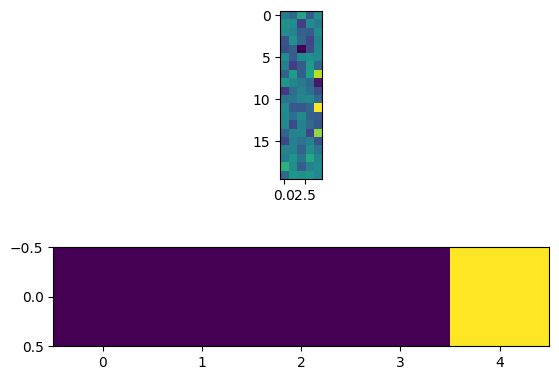

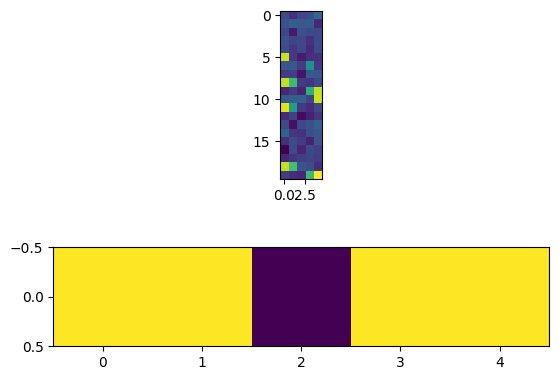

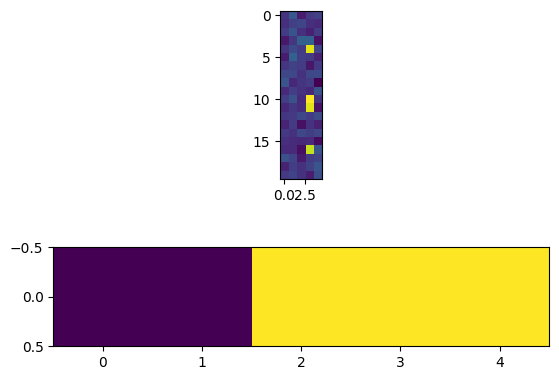

In [7]:
listNumbers = [150,204,420]

for af in listNumbers:
    figure, axis = plt.subplots(2,1)
    axis[0].imshow(complete_data[af])

    axis[1].imshow(complete_labels[af])
    plt.show()



### Class weigths

In [8]:
def generate_class_weights(class_series, multi_class=True, one_hot_encoded=False):
  """
  Method to generate class weights given a set of multi-class or multi-label labels, both one-hot-encoded or not.
  Some examples of different formats of class_series and their outputs are:
    - generate_class_weights(['mango', 'lemon', 'banana', 'mango'], multi_class=True, one_hot_encoded=False)
    {'banana': 1.3333333333333333, 'lemon': 1.3333333333333333, 'mango': 0.6666666666666666}
    - generate_class_weights([[1, 0, 0], [0, 1, 0], [0, 0, 1], [1, 0, 0]], multi_class=True, one_hot_encoded=True)
    {0: 0.6666666666666666, 1: 1.3333333333333333, 2: 1.3333333333333333}
    - generate_class_weights([['mango', 'lemon'], ['mango'], ['lemon', 'banana'], ['lemon']], multi_class=False, one_hot_encoded=False)
    {'banana': 1.3333333333333333, 'lemon': 0.4444444444444444, 'mango': 0.6666666666666666}
    - generate_class_weights([[0, 1, 1], [0, 0, 1], [1, 1, 0], [0, 1, 0]], multi_class=False, one_hot_encoded=True)
    {0: 1.3333333333333333, 1: 0.4444444444444444, 2: 0.6666666666666666}
  The output is a dictionary in the format { class_label: class_weight }. In case the input is one hot encoded, the class_label would be index
  of appareance of the label when the dataset was processed. 
  In multi_class this is np.unique(class_series) and in multi-label np.unique(np.concatenate(class_series)).
  Author: Angel Igareta (angel@igareta.com)
  """
  if multi_class:
    # If class is one hot encoded, transform to categorical labels to use compute_class_weight   
    if one_hot_encoded:
      class_series = np.argmax(class_series, axis=1)
  
    # Compute class weights with sklearn method
    class_labels = np.unique(class_series)
    class_weights = compute_class_weight(class_weight='balanced', classes=class_labels, y=class_series)
    return dict(zip(class_labels, class_weights))
  else:
    # It is neccessary that the multi-label values are one-hot encoded
    mlb = None
    if not one_hot_encoded:
      mlb = preprocessing.MultiLabelBinarizer()
      class_series = mlb.fit_transform(class_series)

    n_samples = len(class_series)
    n_classes = len(class_series[0])

    # Count each class frequency
    class_count = [0] * n_classes
    for classes in class_series:
        for index in range(n_classes):
            if classes[index] != 0:
                class_count[index] += 1
    
    # Compute class weights using balanced method
    class_weights = [n_samples / (n_classes * freq) if freq > 0 else 1 for freq in class_count]
    class_labels = range(len(class_weights)) if mlb is None else mlb.classes_
    return dict(zip(class_labels, class_weights))
  

def weighted_mean_squared_error(class_weight):
  def loss(y_true, y_pred):
          y_true = tf.dtypes.cast(y_true, tf.float32)
          y_pred = tf.dtypes.cast(y_pred, tf.float32)
#             y_pred=  tf.transpose(y_pred, perm=[1, 0,2])

          
          weight = tf.constant(class_weight, dtype=tf.float32)
          weight_per_sample = tf.transpose(tf.gather(weight, tf.argmax(y_true, axis=-1)))
          weight_per_sample = tf.expand_dims(weight_per_sample, axis=-1)
#             losses = tf.keras.losses.mean_squared_error(y_true, y_pred)
          losses = tf.math.square(y_true-y_pred)*weight_per_sample
          return tf.reduce_mean(losses, axis=-1)
  return loss

### Splits data in train and test

In [9]:
data_train, data_test, labels_train, labels_test = train_test_split(complete_data, complete_labels, train_size=0.8, random_state=112)

# One hot encoding
#labels_test = to_categorical(labels_test)
#labels_train = to_categorical(labels_train)

data_train = np.array(data_train)
data_test = np.array(data_test)
labels_train = np.array(labels_train)
labels_test = np.array(labels_test)
print(labels_test.shape)

(32943, 1, 5)


### Normalise data a bit

In [10]:
# Make a scaler from training data
test = data_train[0]

#reshape to 1d features
nr_data_train = data_train.shape[0]
data_train = data_train.reshape(nr_data_train, time_data_amount*channel_width)
nr_data_test = data_test.shape[0]
data_test = data_test.reshape(nr_data_test, time_data_amount*channel_width)

scaler = preprocessing.StandardScaler().fit(data_train)

# scale everything using that scaler
data_train = scaler.transform(data_train)
data_test = scaler.transform(data_test)

#reshaping back to 2d features
data_train = data_train.reshape(nr_data_train, time_data_amount, channel_width)
data_test = data_test.reshape(nr_data_test, time_data_amount, channel_width)

In [11]:
#fix shape
labels_test = labels_test.reshape(nr_data_test,channel_width)
labels_train = labels_train.reshape(nr_data_train,channel_width)
data_train = data_train
data_test = data_test
print(labels_test.shape)
print(labels_train.shape)
print(data_test.shape)
#print(labels_test[1])

(32943, 5)
(131772, 5)
(32943, 20, 5)


In [12]:
labels_test = to_categorical(labels_test)
labels_train = to_categorical(labels_train)
print(labels_test.shape)
#print(labels_test.reshape(920,3,79).shape)
#print(labels_test[1])

(32943, 5, 3)


#### Adding class weights 
Will only be used if weights is set to true in the top

In [13]:
class_weights = [0.75, 0.75, 0.9]
class_weights = np.array([class_weights[i] for i in range(len(class_weights))])
class_weights

array([0.75, 0.75, 0.9 ])

## Building a model

In [15]:
signal_size = time_data_amount

y = layers.Input(shape=(signal_size,channel_width), dtype='float32', name='Input')
x = layers.Reshape((1,time_data_amount,channel_width), input_shape=(time_data_amount,channel_width))(y)


x = layers.Conv2D(4, [6,3], padding='same', activation='relu', use_bias=True,data_format='channels_first')(x)
x = layers.Conv2D(4, [2,5], padding='same', activation='relu', use_bias=True,data_format='channels_first')(x)
x = layers.Dropout(rate=0.1)(x)
x = layers.MaxPool2D(pool_size=2, strides=1, padding='valid', data_format='channels_first')(x)
x = layers.Conv2D(8, 3, padding='same', activation='relu', use_bias=True,data_format='channels_first')(x)
x = layers.Conv2D(8, [2,4], [1,2], padding='same', activation='relu', use_bias=True,data_format='channels_first')(x)
#x = layers.MaxPool2D(pool_size=2, strides=1, padding='valid', data_format='channels_first')(x)
x = layers.Conv2D(8, [1,3], padding='same', activation='relu', use_bias=True,data_format='channels_first')(x)
#x = layers.Conv2D(2, [1,3], padding='valid', activation='relu', use_bias=True,data_format='channels_first')(x)
x = layers.Flatten()(x)


class_layer = [{}]*channel_width
output_layer = [{}]*channel_width
for iter in range(channel_width):
    class_layer[iter] = layers.Dropout(rate=0.2)(x)
    class_layer[iter] = layers.Dense(12,activation='relu')(class_layer[iter])
    class_layer[iter] = layers.Dropout(rate=0.1)(class_layer[iter])
    #class_layer[iter] = layers.Dense(16,activation='relu')(class_layer[iter])
    output_layer[iter] = layers.Dense(nr_classes, activation='softmax', name=('out'+str(iter)))(class_layer[iter])


'''
class1 = layers.Dense(128,activation='relu')(x)
class1 = layers.Dropout(rate=0.1)(class1)
class1 = layers.Dense(32,activation='relu')(class1)
out1 = layers.Dense(nr_classes, activation='softmax', name='out1')(class1)
class2 = layers.Dense(128,activation='relu')(x)
class2 = layers.Dropout(rate=0.1)(class2)
class2 = layers.Dense(32,activation='relu')(class2)
out2 = layers.Dense(nr_classes, activation='softmax', name='out2')(class2)
class3 = layers.Dense(128,activation='relu')(x)
class3 = layers.Dropout(rate=0.1)(class3)
class3 = layers.Dense(32,activation='relu')(class3)
out3 = layers.Dense(nr_classes, activation='softmax', name='out3')(class3)
'''
model = Model(inputs=[y], outputs=[out_layer for out_layer in output_layer])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Input (InputLayer)             [(None, 20, 5)]      0           []                               
                                                                                                  
 reshape_1 (Reshape)            (None, 1, 20, 5)     0           ['Input[0][0]']                  
                                                                                                  
 conv2d_5 (Conv2D)              (None, 4, 20, 5)     76          ['reshape_1[0][0]']              
                                                                                                  
 conv2d_6 (Conv2D)              (None, 4, 20, 5)     164         ['conv2d_5[0][0]']               
                                                                                              

In [17]:
# ------------- model compilation --------------
ourAdam = Adam()
optimizer = tf.keras.optimizers.RMSprop()

if using_weights == True:
        loss_func = weighted_mean_squared_error(class_weights)
else:
        loss_func = 'categorical_crossentropy'

metric_T = 'accuracy'
loss_dict = {}
metric_dict = {}
for iter in range(channel_width):
        loss_dict['out'+str(iter)] = loss_func
        metric_dict['out'+str(iter)] = metric_T



model.compile(optimizer=ourAdam, loss = loss_dict,
              metrics=metric_T) 
                     


In [18]:
#uncomment to load pretrained model
# from tensorflow import keras
# model = keras.models.load_model('bignet')

In [19]:
# Set the model training parameters
# Stop model training when the training loss is not dropped
callbacks_list = [callbacks.EarlyStopping(
                        monitor='val_loss', 
                        patience=35, 
                        verbose=0, 
                        mode='auto',
                        restore_best_weights=True,
                    )
                            ]

# ------------- Starting model Training --------------
BATCH_SIZE = 4096
EPOCH = 800


hist = model.fit(data_train,[labels_train[:,iter,:] for iter in range(channel_width)],
          batch_size = BATCH_SIZE, 
          epochs = EPOCH, 
          callbacks= callbacks_list,
          validation_split=0.25)


Epoch 1/800


2023-05-10 12:29:23.117956: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8600
2023-05-10 12:29:23.684233: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:637] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


25/25 [==============================] - 4s 43ms/step - loss: 5.1346 - out0_loss: 1.0406 - out1_loss: 1.0145 - out2_loss: 1.0124 - out3_loss: 1.0220 - out4_loss: 1.0451 - out0_accuracy: 0.5170 - out1_accuracy: 0.5743 - out2_accuracy: 0.5877 - out3_accuracy: 0.5808 - out4_accuracy: 0.5546 - val_loss: 4.7223 - val_out0_loss: 0.9441 - val_out1_loss: 0.9343 - val_out2_loss: 0.9277 - val_out3_loss: 0.9326 - val_out4_loss: 0.9836 - val_out0_accuracy: 0.6067 - val_out1_accuracy: 0.6160 - val_out2_accuracy: 0.6130 - val_out3_accuracy: 0.6138 - val_out4_accuracy: 0.5764
Epoch 2/800
25/25 [==============================] - 0s 12ms/step - loss: 4.5758 - out0_loss: 0.9167 - out1_loss: 0.8980 - out2_loss: 0.8972 - out3_loss: 0.9076 - out4_loss: 0.9563 - out0_accuracy: 0.6168 - out1_accuracy: 0.6317 - out2_accuracy: 0.6337 - out3_accuracy: 0.6229 - out4_accuracy: 0.5855 - val_loss: 4.1483 - val_out0_loss: 0.8390 - val_out1_loss: 0.8067 - val_out2_loss: 0.7919 - val_out3_loss: 0.8258 - val_out4_loss:

25/25 [==============================] - 0s 12ms/step - loss: 2.5184 - out0_loss: 0.5318 - out1_loss: 0.4652 - out2_loss: 0.4658 - out3_loss: 0.4702 - out4_loss: 0.5855 - out0_accuracy: 0.7925 - out1_accuracy: 0.8200 - out2_accuracy: 0.8123 - out3_accuracy: 0.8145 - out4_accuracy: 0.7783 - val_loss: 2.4225 - val_out0_loss: 0.5116 - val_out1_loss: 0.4471 - val_out2_loss: 0.4482 - val_out3_loss: 0.4510 - val_out4_loss: 0.5646 - val_out0_accuracy: 0.7970 - val_out1_accuracy: 0.8279 - val_out2_accuracy: 0.8202 - val_out3_accuracy: 0.8215 - val_out4_accuracy: 0.7844
Epoch 30/800
25/25 [==============================] - 0s 12ms/step - loss: 2.5052 - out0_loss: 0.5292 - out1_loss: 0.4631 - out2_loss: 0.4626 - out3_loss: 0.4665 - out4_loss: 0.5839 - out0_accuracy: 0.7931 - out1_accuracy: 0.8215 - out2_accuracy: 0.8141 - out3_accuracy: 0.8171 - out4_accuracy: 0.7797 - val_loss: 2.4121 - val_out0_loss: 0.5111 - val_out1_loss: 0.4471 - val_out2_loss: 0.4480 - val_out3_loss: 0.4483 - val_out4_loss

25/25 [==============================] - 0s 12ms/step - loss: 2.0477 - out0_loss: 0.4215 - out1_loss: 0.3791 - out2_loss: 0.3701 - out3_loss: 0.3782 - out4_loss: 0.4988 - out0_accuracy: 0.8479 - out1_accuracy: 0.8633 - out2_accuracy: 0.8692 - out3_accuracy: 0.8643 - out4_accuracy: 0.8199 - val_loss: 1.9613 - val_out0_loss: 0.4098 - val_out1_loss: 0.3696 - val_out2_loss: 0.3521 - val_out3_loss: 0.3588 - val_out4_loss: 0.4709 - val_out0_accuracy: 0.8507 - val_out1_accuracy: 0.8660 - val_out2_accuracy: 0.8765 - val_out3_accuracy: 0.8714 - val_out4_accuracy: 0.8323
Epoch 58/800
25/25 [==============================] - 0s 12ms/step - loss: 2.0573 - out0_loss: 0.4223 - out1_loss: 0.3815 - out2_loss: 0.3719 - out3_loss: 0.3804 - out4_loss: 0.5012 - out0_accuracy: 0.8477 - out1_accuracy: 0.8613 - out2_accuracy: 0.8690 - out3_accuracy: 0.8642 - out4_accuracy: 0.8194 - val_loss: 1.9134 - val_out0_loss: 0.4007 - val_out1_loss: 0.3576 - val_out2_loss: 0.3396 - val_out3_loss: 0.3505 - val_out4_loss

25/25 [==============================] - 0s 12ms/step - loss: 1.8537 - out0_loss: 0.3866 - out1_loss: 0.3416 - out2_loss: 0.3306 - out3_loss: 0.3429 - out4_loss: 0.4519 - out0_accuracy: 0.8628 - out1_accuracy: 0.8784 - out2_accuracy: 0.8866 - out3_accuracy: 0.8794 - out4_accuracy: 0.8440 - val_loss: 1.7112 - val_out0_loss: 0.3609 - val_out1_loss: 0.3172 - val_out2_loss: 0.2999 - val_out3_loss: 0.3126 - val_out4_loss: 0.4206 - val_out0_accuracy: 0.8694 - val_out1_accuracy: 0.8834 - val_out2_accuracy: 0.8969 - val_out3_accuracy: 0.8883 - val_out4_accuracy: 0.8520
Epoch 86/800
25/25 [==============================] - 0s 12ms/step - loss: 1.8498 - out0_loss: 0.3863 - out1_loss: 0.3402 - out2_loss: 0.3291 - out3_loss: 0.3428 - out4_loss: 0.4514 - out0_accuracy: 0.8633 - out1_accuracy: 0.8783 - out2_accuracy: 0.8872 - out3_accuracy: 0.8790 - out4_accuracy: 0.8433 - val_loss: 1.7320 - val_out0_loss: 0.3649 - val_out1_loss: 0.3230 - val_out2_loss: 0.3032 - val_out3_loss: 0.3167 - val_out4_loss

25/25 [==============================] - 0s 12ms/step - loss: 1.7246 - out0_loss: 0.3589 - out1_loss: 0.3175 - out2_loss: 0.3016 - out3_loss: 0.3145 - out4_loss: 0.4321 - out0_accuracy: 0.8735 - out1_accuracy: 0.8874 - out2_accuracy: 0.8995 - out3_accuracy: 0.8913 - out4_accuracy: 0.8509 - val_loss: 1.6527 - val_out0_loss: 0.3462 - val_out1_loss: 0.3079 - val_out2_loss: 0.2875 - val_out3_loss: 0.2992 - val_out4_loss: 0.4119 - val_out0_accuracy: 0.8759 - val_out1_accuracy: 0.8897 - val_out2_accuracy: 0.9033 - val_out3_accuracy: 0.8943 - val_out4_accuracy: 0.8568
Epoch 114/800
25/25 [==============================] - 0s 12ms/step - loss: 1.7324 - out0_loss: 0.3610 - out1_loss: 0.3179 - out2_loss: 0.3040 - out3_loss: 0.3157 - out4_loss: 0.4339 - out0_accuracy: 0.8731 - out1_accuracy: 0.8863 - out2_accuracy: 0.8971 - out3_accuracy: 0.8901 - out4_accuracy: 0.8505 - val_loss: 1.6042 - val_out0_loss: 0.3388 - val_out1_loss: 0.2987 - val_out2_loss: 0.2752 - val_out3_loss: 0.2888 - val_out4_los

25/25 [==============================] - 0s 12ms/step - loss: 1.6340 - out0_loss: 0.3420 - out1_loss: 0.2992 - out2_loss: 0.2845 - out3_loss: 0.2963 - out4_loss: 0.4120 - out0_accuracy: 0.8809 - out1_accuracy: 0.8940 - out2_accuracy: 0.9059 - out3_accuracy: 0.8981 - out4_accuracy: 0.8598 - val_loss: 1.5293 - val_out0_loss: 0.3220 - val_out1_loss: 0.2830 - val_out2_loss: 0.2597 - val_out3_loss: 0.2761 - val_out4_loss: 0.3884 - val_out0_accuracy: 0.8860 - val_out1_accuracy: 0.8993 - val_out2_accuracy: 0.9142 - val_out3_accuracy: 0.9039 - val_out4_accuracy: 0.8666
Epoch 142/800
25/25 [==============================] - 0s 12ms/step - loss: 1.6345 - out0_loss: 0.3422 - out1_loss: 0.2990 - out2_loss: 0.2843 - out3_loss: 0.2962 - out4_loss: 0.4129 - out0_accuracy: 0.8802 - out1_accuracy: 0.8942 - out2_accuracy: 0.9057 - out3_accuracy: 0.8977 - out4_accuracy: 0.8588 - val_loss: 1.5409 - val_out0_loss: 0.3250 - val_out1_loss: 0.2870 - val_out2_loss: 0.2628 - val_out3_loss: 0.2779 - val_out4_los

25/25 [==============================] - 0s 12ms/step - loss: 1.5786 - out0_loss: 0.3316 - out1_loss: 0.2892 - out2_loss: 0.2717 - out3_loss: 0.2856 - out4_loss: 0.4005 - out0_accuracy: 0.8847 - out1_accuracy: 0.8973 - out2_accuracy: 0.9107 - out3_accuracy: 0.9013 - out4_accuracy: 0.8635 - val_loss: 1.4823 - val_out0_loss: 0.3112 - val_out1_loss: 0.2727 - val_out2_loss: 0.2495 - val_out3_loss: 0.2669 - val_out4_loss: 0.3821 - val_out0_accuracy: 0.8911 - val_out1_accuracy: 0.9035 - val_out2_accuracy: 0.9171 - val_out3_accuracy: 0.9057 - val_out4_accuracy: 0.8670
Epoch 170/800
25/25 [==============================] - 0s 12ms/step - loss: 1.5794 - out0_loss: 0.3312 - out1_loss: 0.2894 - out2_loss: 0.2741 - out3_loss: 0.2856 - out4_loss: 0.3991 - out0_accuracy: 0.8858 - out1_accuracy: 0.8982 - out2_accuracy: 0.9099 - out3_accuracy: 0.9027 - out4_accuracy: 0.8636 - val_loss: 1.4613 - val_out0_loss: 0.3094 - val_out1_loss: 0.2696 - val_out2_loss: 0.2449 - val_out3_loss: 0.2615 - val_out4_los

25/25 [==============================] - 0s 12ms/step - loss: 1.5284 - out0_loss: 0.3226 - out1_loss: 0.2788 - out2_loss: 0.2611 - out3_loss: 0.2756 - out4_loss: 0.3903 - out0_accuracy: 0.8887 - out1_accuracy: 0.9014 - out2_accuracy: 0.9146 - out3_accuracy: 0.9059 - out4_accuracy: 0.8678 - val_loss: 1.4424 - val_out0_loss: 0.3048 - val_out1_loss: 0.2655 - val_out2_loss: 0.2406 - val_out3_loss: 0.2586 - val_out4_loss: 0.3728 - val_out0_accuracy: 0.8944 - val_out1_accuracy: 0.9071 - val_out2_accuracy: 0.9220 - val_out3_accuracy: 0.9106 - val_out4_accuracy: 0.8711
Epoch 198/800
25/25 [==============================] - 0s 12ms/step - loss: 1.5250 - out0_loss: 0.3214 - out1_loss: 0.2784 - out2_loss: 0.2606 - out3_loss: 0.2740 - out4_loss: 0.3905 - out0_accuracy: 0.8896 - out1_accuracy: 0.9011 - out2_accuracy: 0.9145 - out3_accuracy: 0.9062 - out4_accuracy: 0.8672 - val_loss: 1.4489 - val_out0_loss: 0.3066 - val_out1_loss: 0.2690 - val_out2_loss: 0.2433 - val_out3_loss: 0.2606 - val_out4_los

25/25 [==============================] - 0s 12ms/step - loss: 1.4895 - out0_loss: 0.3148 - out1_loss: 0.2706 - out2_loss: 0.2536 - out3_loss: 0.2668 - out4_loss: 0.3837 - out0_accuracy: 0.8919 - out1_accuracy: 0.9043 - out2_accuracy: 0.9176 - out3_accuracy: 0.9092 - out4_accuracy: 0.8700 - val_loss: 1.4160 - val_out0_loss: 0.3017 - val_out1_loss: 0.2612 - val_out2_loss: 0.2342 - val_out3_loss: 0.2546 - val_out4_loss: 0.3643 - val_out0_accuracy: 0.8960 - val_out1_accuracy: 0.9101 - val_out2_accuracy: 0.9257 - val_out3_accuracy: 0.9118 - val_out4_accuracy: 0.8751
Epoch 226/800
25/25 [==============================] - 0s 12ms/step - loss: 1.4873 - out0_loss: 0.3150 - out1_loss: 0.2706 - out2_loss: 0.2540 - out3_loss: 0.2673 - out4_loss: 0.3804 - out0_accuracy: 0.8914 - out1_accuracy: 0.9047 - out2_accuracy: 0.9172 - out3_accuracy: 0.9094 - out4_accuracy: 0.8706 - val_loss: 1.3909 - val_out0_loss: 0.2956 - val_out1_loss: 0.2553 - val_out2_loss: 0.2310 - val_out3_loss: 0.2495 - val_out4_los

25/25 [==============================] - 0s 12ms/step - loss: 1.4574 - out0_loss: 0.3082 - out1_loss: 0.2651 - out2_loss: 0.2465 - out3_loss: 0.2611 - out4_loss: 0.3765 - out0_accuracy: 0.8939 - out1_accuracy: 0.9066 - out2_accuracy: 0.9209 - out3_accuracy: 0.9105 - out4_accuracy: 0.8722 - val_loss: 1.3738 - val_out0_loss: 0.2914 - val_out1_loss: 0.2517 - val_out2_loss: 0.2265 - val_out3_loss: 0.2464 - val_out4_loss: 0.3577 - val_out0_accuracy: 0.8996 - val_out1_accuracy: 0.9134 - val_out2_accuracy: 0.9284 - val_out3_accuracy: 0.9147 - val_out4_accuracy: 0.8769
Epoch 254/800
25/25 [==============================] - 0s 12ms/step - loss: 1.4597 - out0_loss: 0.3090 - out1_loss: 0.2654 - out2_loss: 0.2479 - out3_loss: 0.2607 - out4_loss: 0.3767 - out0_accuracy: 0.8947 - out1_accuracy: 0.9071 - out2_accuracy: 0.9206 - out3_accuracy: 0.9122 - out4_accuracy: 0.8730 - val_loss: 1.3651 - val_out0_loss: 0.2887 - val_out1_loss: 0.2495 - val_out2_loss: 0.2245 - val_out3_loss: 0.2448 - val_out4_los

25/25 [==============================] - 0s 12ms/step - loss: 1.4370 - out0_loss: 0.3044 - out1_loss: 0.2603 - out2_loss: 0.2419 - out3_loss: 0.2576 - out4_loss: 0.3727 - out0_accuracy: 0.8963 - out1_accuracy: 0.9079 - out2_accuracy: 0.9221 - out3_accuracy: 0.9130 - out4_accuracy: 0.8734 - val_loss: 1.3982 - val_out0_loss: 0.2979 - val_out1_loss: 0.2579 - val_out2_loss: 0.2311 - val_out3_loss: 0.2513 - val_out4_loss: 0.3599 - val_out0_accuracy: 0.8979 - val_out1_accuracy: 0.9109 - val_out2_accuracy: 0.9262 - val_out3_accuracy: 0.9130 - val_out4_accuracy: 0.8773
Epoch 282/800
25/25 [==============================] - 0s 12ms/step - loss: 1.4375 - out0_loss: 0.3047 - out1_loss: 0.2610 - out2_loss: 0.2427 - out3_loss: 0.2572 - out4_loss: 0.3719 - out0_accuracy: 0.8957 - out1_accuracy: 0.9083 - out2_accuracy: 0.9223 - out3_accuracy: 0.9122 - out4_accuracy: 0.8744 - val_loss: 1.3482 - val_out0_loss: 0.2868 - val_out1_loss: 0.2468 - val_out2_loss: 0.2214 - val_out3_loss: 0.2412 - val_out4_los

25/25 [==============================] - 0s 12ms/step - loss: 1.4282 - out0_loss: 0.3026 - out1_loss: 0.2571 - out2_loss: 0.2409 - out3_loss: 0.2565 - out4_loss: 0.3710 - out0_accuracy: 0.8967 - out1_accuracy: 0.9093 - out2_accuracy: 0.9236 - out3_accuracy: 0.9131 - out4_accuracy: 0.8745 - val_loss: 1.3487 - val_out0_loss: 0.2863 - val_out1_loss: 0.2464 - val_out2_loss: 0.2201 - val_out3_loss: 0.2414 - val_out4_loss: 0.3546 - val_out0_accuracy: 0.9020 - val_out1_accuracy: 0.9152 - val_out2_accuracy: 0.9306 - val_out3_accuracy: 0.9161 - val_out4_accuracy: 0.8789
Epoch 310/800
25/25 [==============================] - 0s 12ms/step - loss: 1.4236 - out0_loss: 0.3015 - out1_loss: 0.2580 - out2_loss: 0.2386 - out3_loss: 0.2547 - out4_loss: 0.3709 - out0_accuracy: 0.8976 - out1_accuracy: 0.9092 - out2_accuracy: 0.9233 - out3_accuracy: 0.9131 - out4_accuracy: 0.8741 - val_loss: 1.3880 - val_out0_loss: 0.2967 - val_out1_loss: 0.2565 - val_out2_loss: 0.2290 - val_out3_loss: 0.2488 - val_out4_los

25/25 [==============================] - 0s 12ms/step - loss: 1.3987 - out0_loss: 0.2976 - out1_loss: 0.2528 - out2_loss: 0.2313 - out3_loss: 0.2506 - out4_loss: 0.3664 - out0_accuracy: 0.8992 - out1_accuracy: 0.9109 - out2_accuracy: 0.9267 - out3_accuracy: 0.9156 - out4_accuracy: 0.8754 - val_loss: 1.3309 - val_out0_loss: 0.2832 - val_out1_loss: 0.2423 - val_out2_loss: 0.2152 - val_out3_loss: 0.2374 - val_out4_loss: 0.3529 - val_out0_accuracy: 0.9036 - val_out1_accuracy: 0.9162 - val_out2_accuracy: 0.9323 - val_out3_accuracy: 0.9186 - val_out4_accuracy: 0.8797
Epoch 338/800
25/25 [==============================] - 0s 12ms/step - loss: 1.4000 - out0_loss: 0.2965 - out1_loss: 0.2522 - out2_loss: 0.2332 - out3_loss: 0.2511 - out4_loss: 0.3671 - out0_accuracy: 0.8988 - out1_accuracy: 0.9119 - out2_accuracy: 0.9257 - out3_accuracy: 0.9148 - out4_accuracy: 0.8756 - val_loss: 1.3266 - val_out0_loss: 0.2824 - val_out1_loss: 0.2422 - val_out2_loss: 0.2149 - val_out3_loss: 0.2370 - val_out4_los

25/25 [==============================] - 0s 12ms/step - loss: 1.3789 - out0_loss: 0.2912 - out1_loss: 0.2489 - out2_loss: 0.2284 - out3_loss: 0.2461 - out4_loss: 0.3643 - out0_accuracy: 0.9012 - out1_accuracy: 0.9118 - out2_accuracy: 0.9276 - out3_accuracy: 0.9165 - out4_accuracy: 0.8761 - val_loss: 1.2932 - val_out0_loss: 0.2751 - val_out1_loss: 0.2344 - val_out2_loss: 0.2079 - val_out3_loss: 0.2313 - val_out4_loss: 0.3445 - val_out0_accuracy: 0.9061 - val_out1_accuracy: 0.9182 - val_out2_accuracy: 0.9341 - val_out3_accuracy: 0.9199 - val_out4_accuracy: 0.8829
Epoch 366/800
25/25 [==============================] - 0s 11ms/step - loss: 1.3855 - out0_loss: 0.2933 - out1_loss: 0.2492 - out2_loss: 0.2296 - out3_loss: 0.2480 - out4_loss: 0.3653 - out0_accuracy: 0.9002 - out1_accuracy: 0.9121 - out2_accuracy: 0.9277 - out3_accuracy: 0.9160 - out4_accuracy: 0.8761 - val_loss: 1.3021 - val_out0_loss: 0.2750 - val_out1_loss: 0.2359 - val_out2_loss: 0.2094 - val_out3_loss: 0.2330 - val_out4_los

25/25 [==============================] - 0s 12ms/step - loss: 1.3723 - out0_loss: 0.2891 - out1_loss: 0.2471 - out2_loss: 0.2269 - out3_loss: 0.2462 - out4_loss: 0.3630 - out0_accuracy: 0.9016 - out1_accuracy: 0.9126 - out2_accuracy: 0.9284 - out3_accuracy: 0.9169 - out4_accuracy: 0.8773 - val_loss: 1.2926 - val_out0_loss: 0.2742 - val_out1_loss: 0.2350 - val_out2_loss: 0.2082 - val_out3_loss: 0.2315 - val_out4_loss: 0.3436 - val_out0_accuracy: 0.9057 - val_out1_accuracy: 0.9189 - val_out2_accuracy: 0.9341 - val_out3_accuracy: 0.9201 - val_out4_accuracy: 0.8839
Epoch 394/800
25/25 [==============================] - 0s 12ms/step - loss: 1.3647 - out0_loss: 0.2882 - out1_loss: 0.2453 - out2_loss: 0.2247 - out3_loss: 0.2450 - out4_loss: 0.3615 - out0_accuracy: 0.9022 - out1_accuracy: 0.9149 - out2_accuracy: 0.9288 - out3_accuracy: 0.9173 - out4_accuracy: 0.8776 - val_loss: 1.3076 - val_out0_loss: 0.2785 - val_out1_loss: 0.2384 - val_out2_loss: 0.2111 - val_out3_loss: 0.2334 - val_out4_los

25/25 [==============================] - 0s 12ms/step - loss: 1.3506 - out0_loss: 0.2857 - out1_loss: 0.2428 - out2_loss: 0.2206 - out3_loss: 0.2422 - out4_loss: 0.3593 - out0_accuracy: 0.9027 - out1_accuracy: 0.9152 - out2_accuracy: 0.9308 - out3_accuracy: 0.9178 - out4_accuracy: 0.8782 - val_loss: 1.2772 - val_out0_loss: 0.2710 - val_out1_loss: 0.2318 - val_out2_loss: 0.2039 - val_out3_loss: 0.2279 - val_out4_loss: 0.3425 - val_out0_accuracy: 0.9086 - val_out1_accuracy: 0.9205 - val_out2_accuracy: 0.9374 - val_out3_accuracy: 0.9233 - val_out4_accuracy: 0.8845
Epoch 422/800
25/25 [==============================] - 0s 12ms/step - loss: 1.3472 - out0_loss: 0.2848 - out1_loss: 0.2417 - out2_loss: 0.2210 - out3_loss: 0.2409 - out4_loss: 0.3589 - out0_accuracy: 0.9034 - out1_accuracy: 0.9149 - out2_accuracy: 0.9303 - out3_accuracy: 0.9185 - out4_accuracy: 0.8780 - val_loss: 1.2805 - val_out0_loss: 0.2716 - val_out1_loss: 0.2324 - val_out2_loss: 0.2047 - val_out3_loss: 0.2287 - val_out4_los

25/25 [==============================] - 0s 11ms/step - loss: 1.3377 - out0_loss: 0.2814 - out1_loss: 0.2410 - out2_loss: 0.2196 - out3_loss: 0.2391 - out4_loss: 0.3565 - out0_accuracy: 0.9041 - out1_accuracy: 0.9153 - out2_accuracy: 0.9311 - out3_accuracy: 0.9196 - out4_accuracy: 0.8789 - val_loss: 1.2947 - val_out0_loss: 0.2738 - val_out1_loss: 0.2361 - val_out2_loss: 0.2088 - val_out3_loss: 0.2321 - val_out4_loss: 0.3438 - val_out0_accuracy: 0.9075 - val_out1_accuracy: 0.9186 - val_out2_accuracy: 0.9349 - val_out3_accuracy: 0.9213 - val_out4_accuracy: 0.8843
Epoch 450/800
25/25 [==============================] - 0s 11ms/step - loss: 1.3411 - out0_loss: 0.2818 - out1_loss: 0.2410 - out2_loss: 0.2191 - out3_loss: 0.2397 - out4_loss: 0.3595 - out0_accuracy: 0.9043 - out1_accuracy: 0.9156 - out2_accuracy: 0.9312 - out3_accuracy: 0.9186 - out4_accuracy: 0.8790 - val_loss: 1.2601 - val_out0_loss: 0.2657 - val_out1_loss: 0.2270 - val_out2_loss: 0.2002 - val_out3_loss: 0.2257 - val_out4_los

25/25 [==============================] - 0s 12ms/step - loss: 1.3387 - out0_loss: 0.2812 - out1_loss: 0.2416 - out2_loss: 0.2183 - out3_loss: 0.2393 - out4_loss: 0.3582 - out0_accuracy: 0.9048 - out1_accuracy: 0.9163 - out2_accuracy: 0.9315 - out3_accuracy: 0.9187 - out4_accuracy: 0.8789 - val_loss: 1.2558 - val_out0_loss: 0.2649 - val_out1_loss: 0.2267 - val_out2_loss: 0.1991 - val_out3_loss: 0.2252 - val_out4_loss: 0.3398 - val_out0_accuracy: 0.9111 - val_out1_accuracy: 0.9218 - val_out2_accuracy: 0.9374 - val_out3_accuracy: 0.9235 - val_out4_accuracy: 0.8847
Epoch 478/800
25/25 [==============================] - 0s 12ms/step - loss: 1.3324 - out0_loss: 0.2820 - out1_loss: 0.2395 - out2_loss: 0.2169 - out3_loss: 0.2373 - out4_loss: 0.3566 - out0_accuracy: 0.9050 - out1_accuracy: 0.9158 - out2_accuracy: 0.9316 - out3_accuracy: 0.9209 - out4_accuracy: 0.8789 - val_loss: 1.2724 - val_out0_loss: 0.2695 - val_out1_loss: 0.2302 - val_out2_loss: 0.2019 - val_out3_loss: 0.2273 - val_out4_los

25/25 [==============================] - 0s 12ms/step - loss: 1.3198 - out0_loss: 0.2767 - out1_loss: 0.2367 - out2_loss: 0.2148 - out3_loss: 0.2370 - out4_loss: 0.3545 - out0_accuracy: 0.9065 - out1_accuracy: 0.9176 - out2_accuracy: 0.9330 - out3_accuracy: 0.9193 - out4_accuracy: 0.8793 - val_loss: 1.2543 - val_out0_loss: 0.2637 - val_out1_loss: 0.2267 - val_out2_loss: 0.1992 - val_out3_loss: 0.2251 - val_out4_loss: 0.3396 - val_out0_accuracy: 0.9115 - val_out1_accuracy: 0.9218 - val_out2_accuracy: 0.9381 - val_out3_accuracy: 0.9234 - val_out4_accuracy: 0.8850
Epoch 506/800
25/25 [==============================] - 0s 12ms/step - loss: 1.3191 - out0_loss: 0.2785 - out1_loss: 0.2360 - out2_loss: 0.2152 - out3_loss: 0.2360 - out4_loss: 0.3535 - out0_accuracy: 0.9060 - out1_accuracy: 0.9172 - out2_accuracy: 0.9322 - out3_accuracy: 0.9197 - out4_accuracy: 0.8804 - val_loss: 1.2713 - val_out0_loss: 0.2691 - val_out1_loss: 0.2310 - val_out2_loss: 0.2013 - val_out3_loss: 0.2280 - val_out4_los

25/25 [==============================] - 0s 12ms/step - loss: 1.3188 - out0_loss: 0.2777 - out1_loss: 0.2366 - out2_loss: 0.2139 - out3_loss: 0.2355 - out4_loss: 0.3551 - out0_accuracy: 0.9061 - out1_accuracy: 0.9174 - out2_accuracy: 0.9326 - out3_accuracy: 0.9196 - out4_accuracy: 0.8806 - val_loss: 1.2409 - val_out0_loss: 0.2621 - val_out1_loss: 0.2232 - val_out2_loss: 0.1943 - val_out3_loss: 0.2218 - val_out4_loss: 0.3395 - val_out0_accuracy: 0.9121 - val_out1_accuracy: 0.9229 - val_out2_accuracy: 0.9397 - val_out3_accuracy: 0.9256 - val_out4_accuracy: 0.8880
Epoch 534/800
25/25 [==============================] - 0s 11ms/step - loss: 1.3209 - out0_loss: 0.2786 - out1_loss: 0.2368 - out2_loss: 0.2146 - out3_loss: 0.2359 - out4_loss: 0.3550 - out0_accuracy: 0.9057 - out1_accuracy: 0.9175 - out2_accuracy: 0.9326 - out3_accuracy: 0.9199 - out4_accuracy: 0.8803 - val_loss: 1.2560 - val_out0_loss: 0.2664 - val_out1_loss: 0.2276 - val_out2_loss: 0.1984 - val_out3_loss: 0.2246 - val_out4_los

25/25 [==============================] - 0s 11ms/step - loss: 1.3002 - out0_loss: 0.2732 - out1_loss: 0.2330 - out2_loss: 0.2107 - out3_loss: 0.2330 - out4_loss: 0.3503 - out0_accuracy: 0.9087 - out1_accuracy: 0.9184 - out2_accuracy: 0.9341 - out3_accuracy: 0.9212 - out4_accuracy: 0.8823 - val_loss: 1.2397 - val_out0_loss: 0.2620 - val_out1_loss: 0.2248 - val_out2_loss: 0.1947 - val_out3_loss: 0.2226 - val_out4_loss: 0.3356 - val_out0_accuracy: 0.9129 - val_out1_accuracy: 0.9237 - val_out2_accuracy: 0.9405 - val_out3_accuracy: 0.9252 - val_out4_accuracy: 0.8879
Epoch 562/800
25/25 [==============================] - 0s 11ms/step - loss: 1.3001 - out0_loss: 0.2735 - out1_loss: 0.2333 - out2_loss: 0.2105 - out3_loss: 0.2320 - out4_loss: 0.3508 - out0_accuracy: 0.9078 - out1_accuracy: 0.9181 - out2_accuracy: 0.9336 - out3_accuracy: 0.9210 - out4_accuracy: 0.8819 - val_loss: 1.2354 - val_out0_loss: 0.2599 - val_out1_loss: 0.2227 - val_out2_loss: 0.1933 - val_out3_loss: 0.2210 - val_out4_los

25/25 [==============================] - 0s 12ms/step - loss: 1.2980 - out0_loss: 0.2729 - out1_loss: 0.2342 - out2_loss: 0.2094 - out3_loss: 0.2327 - out4_loss: 0.3489 - out0_accuracy: 0.9090 - out1_accuracy: 0.9183 - out2_accuracy: 0.9349 - out3_accuracy: 0.9209 - out4_accuracy: 0.8825 - val_loss: 1.2297 - val_out0_loss: 0.2606 - val_out1_loss: 0.2224 - val_out2_loss: 0.1921 - val_out3_loss: 0.2205 - val_out4_loss: 0.3341 - val_out0_accuracy: 0.9135 - val_out1_accuracy: 0.9240 - val_out2_accuracy: 0.9417 - val_out3_accuracy: 0.9261 - val_out4_accuracy: 0.8882
Epoch 590/800
25/25 [==============================] - 0s 11ms/step - loss: 1.2914 - out0_loss: 0.2720 - out1_loss: 0.2308 - out2_loss: 0.2079 - out3_loss: 0.2327 - out4_loss: 0.3480 - out0_accuracy: 0.9082 - out1_accuracy: 0.9192 - out2_accuracy: 0.9352 - out3_accuracy: 0.9210 - out4_accuracy: 0.8833 - val_loss: 1.2614 - val_out0_loss: 0.2676 - val_out1_loss: 0.2303 - val_out2_loss: 0.1990 - val_out3_loss: 0.2262 - val_out4_los

In [20]:
def createDir(path: str):
    isExist = os.path.exists(path)
    if not isExist:
        os.makedirs(path)
        print('Created "' + path + '" directory')
    else:
        print('"'+ path + '" directory already existed')

createDir(save_folder)

Created "template_Multi20" directory


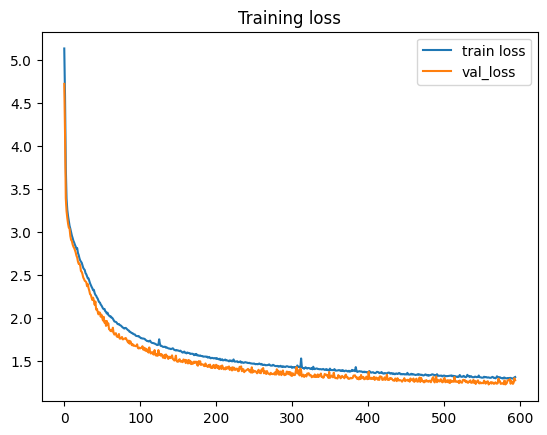

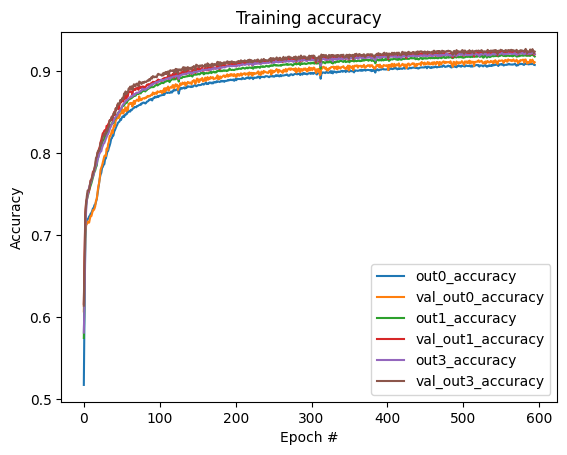

In [21]:
# Show loss curves
plt.figure()
plt.title('Training loss')
plt.plot(hist.epoch, hist.history['loss'], label='train loss')
plt.plot(hist.epoch, hist.history['val_loss'], label='val_loss')
plt.legend()
plt.savefig(save_folder + '/%s Training loss.pdf' %(name), format='pdf')
# plt.show()

plt.figure()
plt.title('Training accuracy')
plt.xlabel("Epoch #")
plt.ylabel("Accuracy")

lossNames = ['out0_accuracy', 'out'+str(math.floor(channel_width/3))+'_accuracy', 'out'+str(math.floor(channel_width*2/3))+'_accuracy']
for (i, l) in enumerate(lossNames):
	# plot the loss for both the training and validation data
	title = "Loss for {}".format(l) if l != "loss" else "Total loss"
	plt.plot(hist.epoch, hist.history[l], label=l)
	plt.plot(hist.epoch, hist.history["val_" + l],
		label="val_" + l)
	plt.legend()
plt.savefig(save_folder + '/%s Training acc.pdf' %(name), format='pdf')
plt.show()


In [22]:
evalDict = model.evaluate(data_test,[labels_test[:,iter,:] for iter in range(channel_width)])

1030/1030 [==============================] - 3s 3ms/step - loss: 1.1899 - out0_loss: 0.2530 - out1_loss: 0.2096 - out2_loss: 0.1843 - out3_loss: 0.2099 - out4_loss: 0.3331 - out0_accuracy: 0.9141 - out1_accuracy: 0.9286 - out2_accuracy: 0.9444 - out3_accuracy: 0.9292 - out4_accuracy: 0.8884


In [ ]:
totalA = 0
for i in range(channel_width+1,channel_width+1+channel_width):
    totalA += evalDict[i]

totalA /= channel_width
print(totalA)

In [23]:
from keras.utils.layer_utils import count_params
test = count_params(model.trainable_weights)
test
cre = open(save_folder + '/' + 'Params_' + str(test), 'x')

0.9209300875663757


In [24]:
# Saving dict of history and evaluation result
with open(save_folder + '/' + 'histDict', 'wb') as file_pi:
    pickle.dump(hist.history, file_pi)

with open(save_folder + '/' + 'evalDict' + str(totalA), 'wb') as file_pi:
    pickle.dump(evalDict, file_pi)

In [25]:
#uncomment to save model
model.save(save_folder + '/' + name + '_Model')

2023-05-10 12:33:03.543087: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Input' with dtype float and shape [?,20,5]
	 [[{{node Input}}]]
2023-05-10 12:33:03.660674: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Input' with dtype float and shape [?,20,5]
	 [[{{node Input}}]]
2023-05-10 12:33:03.706437: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,20,5]
	 [[{{node inputs}}]]
2023-05-10 12:33:

2023-05-10 12:33:04.201468: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,304]
	 [[{{node inputs}}]]
2023-05-10 12:33:04.212499: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,304]
	 [[{{node inputs}}]]
2023-05-10 12:33:04.223262: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,304]
	 [[{{node inputs}}]]
2023-05-10 12:33

INFO:tensorflow:Assets written to: template_Multi20/multi_channels_test_Model/assets


INFO:tensorflow:Assets written to: template_Multi20/multi_channels_test_Model/assets


In [26]:
#Test on test data
true_test_labels = np.argmax(labels_test, axis=-1)
test_predictions = model.predict(data_test)
test_result = np.argmax(test_predictions, axis=-1).T

1030/1030 [==============================] - 2s 2ms/step


In [27]:
#classification report
class_names = ['Empty channel', 'Wi-Fi', 'Bluetooth']
class_report = classification_report(true_test_labels.flatten(), test_result.flatten(),target_names=class_names)
print(class_report)

with open(save_folder + '/' + 'classReportString', 'wb') as file_pi:
    pickle.dump(class_report, file_pi)

               precision    recall  f1-score   support

Empty channel       0.91      0.98      0.94     99959
        Wi-Fi       0.98      0.89      0.93     33921
    Bluetooth       0.91      0.76      0.83     30835

     accuracy                           0.92    164715
    macro avg       0.93      0.88      0.90    164715
 weighted avg       0.92      0.92      0.92    164715



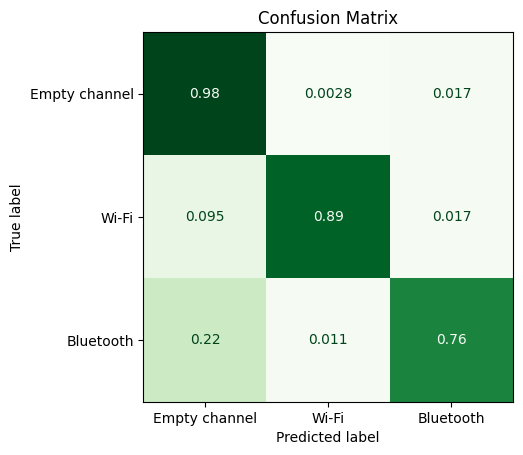

In [28]:
#Confusion matric plot
ConfusionMatrixDisplay.from_predictions(true_test_labels.flatten(), test_result.flatten(),normalize='true',cmap='Greens',colorbar=False,display_labels=class_names)
plt.title('Confusion Matrix')
plt.savefig(save_folder +'/confusion_matrix_'+ name +'.pdf', format='pdf')

In [29]:
class_reportDict = classification_report(true_test_labels.flatten(), test_result.flatten(),output_dict=True, target_names=class_names)
for key in class_reportDict:
    try:
        class_reportDict[key]['Samples'] = class_reportDict[key].pop('support')
    except Exception as e:
        print(e)
print(class_reportDict)


'float' object has no attribute 'pop'
{'Empty channel': {'precision': 0.9061000748759002, 'recall': 0.9806120509408858, 'f1-score': 0.9418847111051322, 'Samples': 99959}, 'Wi-Fi': {'precision': 0.9797578755532413, 'recall': 0.8875327967925474, 'f1-score': 0.9313678479172144, 'Samples': 33921}, 'Bluetooth': {'precision': 0.9130502169869807, 'recall': 0.7641965299173018, 'f1-score': 0.8320180781385166, 'Samples': 30835}, 'accuracy': 0.920930091369942, 'macro avg': {'precision': 0.9329693891387074, 'recall': 0.8774471258835783, 'f1-score': 0.9017568790536211, 'Samples': 164715}, 'weighted avg': {'precision': 0.9225700617548805, 'recall': 0.920930091369942, 'f1-score': 0.9191516258140358, 'Samples': 164715}}


In [30]:
class_reportDict.pop('accuracy')
print(class_reportDict)

{'Empty channel': {'precision': 0.9061000748759002, 'recall': 0.9806120509408858, 'f1-score': 0.9418847111051322, 'Samples': 99959}, 'Wi-Fi': {'precision': 0.9797578755532413, 'recall': 0.8875327967925474, 'f1-score': 0.9313678479172144, 'Samples': 33921}, 'Bluetooth': {'precision': 0.9130502169869807, 'recall': 0.7641965299173018, 'f1-score': 0.8320180781385166, 'Samples': 30835}, 'macro avg': {'precision': 0.9329693891387074, 'recall': 0.8774471258835783, 'f1-score': 0.9017568790536211, 'Samples': 164715}, 'weighted avg': {'precision': 0.9225700617548805, 'recall': 0.920930091369942, 'f1-score': 0.9191516258140358, 'Samples': 164715}}


In [31]:
df = pd.DataFrame(class_reportDict).transpose().round(decimals=3)
dfi.export(df, save_folder + '/' +name + "_ClassReport.png", table_conversion="matplotlib")

In [ ]:
#'animated' data prediction check
'''#outcommentted while running batches
%matplotlib qt
fig,ax = plt.subplots(3)

for i in range(20):
    ax[0].images.clear()
    ax[1].images.clear()
    ax[2].images.clear()

    ax[0].imshow(np.reshape(data_test[i],(20,total_channels)))
    ax[0].set_title('Data')

    ax[1].imshow([true_test_labels[i]],vmin=0,vmax=2)
    ax[1].set_title('Label')
    ax[1].axis('off')

    result = model.predict(np.expand_dims(data_test[i], axis=0))
    ax[2].imshow( [[x.argmax() for x in result]] ,vmin=0,vmax=2)
    ax[2].set_title('Predict')
    ax[2].axis('off')
    
    plt.pause(1)
%matplotlib inline
'''